# **Visão geral**

O conjunto de dados de resenhas de filmes do Rotten Tomatoes é um corpus de resenhas de filmes usado para análise de sentimentos, originalmente coletado por Pang e Lee [1]. Em seu trabalho sobre bancos de árvores de sentimentos, Socher et al. [2] usaram o Mechanical Turk da Amazon para criar rótulos refinados para todas as frases analisadas no corpus.

 Esta competição oferece uma chance de comparar suas ideias de análise de sentimentos no conjunto de dados do Rotten Tomatoes. Você deve rotular frases em uma escala de cinco valores: negativo, um tanto negativo, neutro, um tanto positivo, positivo. Obstáculos como negação de frases, sarcasmo, concisão, ambiguidade da linguagem e muitos outros tornam essa tarefa muito desafiadora.

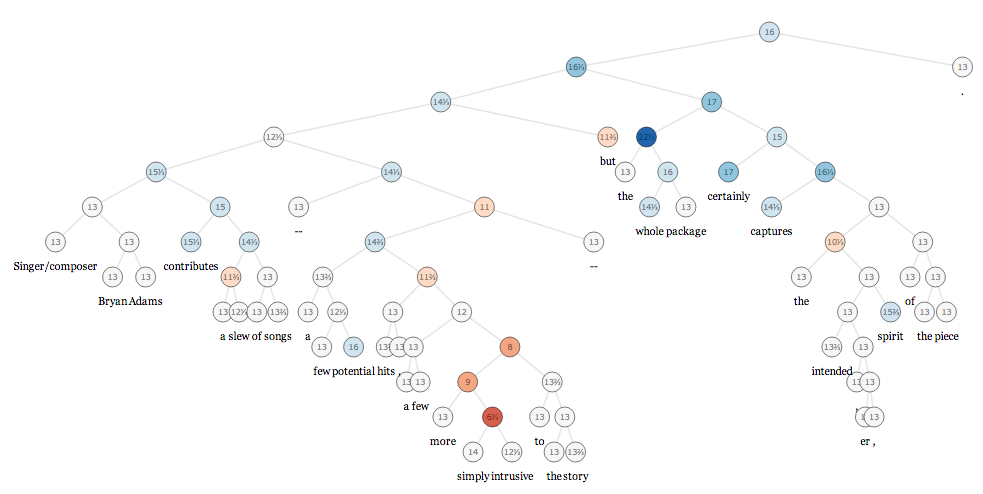

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords') 
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Coleta e Preparação de Dados**

## **Dados**

In [86]:
train = pd.read_csv('Dados/train.tsv', sep='\t')
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [87]:
test = pd.read_csv('Dados/test.tsv', sep='\t')
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


Redução nos dados ⅓ 

In [88]:
print(f"Tamanho original do DataFrame de Treino: {len(train)} linhas")
print(f"Tamanho original do DataFrame de Teste: {len(test)} linhas")

Tamanho original do DataFrame de Treino: 156060 linhas
Tamanho original do DataFrame de Teste: 66292 linhas


In [89]:
train_reduzido = train.sample(n=52020, random_state=42)
test_reduzido = test.sample(n=22100, random_state=42)

In [90]:
print(f"Tamanho original do DataFrame de Treino Reduzido: {len(train_reduzido)} linhas")
print(f"Tamanho original do DataFrame de Teste Reduzido: {len(test_reduzido)} linhas")

Tamanho original do DataFrame de Treino Reduzido: 52020 linhas
Tamanho original do DataFrame de Teste Reduzido: 22100 linhas


In [91]:
train = train_reduzido
test = test_reduzido 

## **Pré-processamento**

In [92]:
stop_words = list(stopwords.words('english')) 

In [93]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    tokens = word_tokenize(text) #Tokenize the text
    tokens = [word for word in tokens if word.isalpha()]  # Remove numeros e simbolos
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

In [94]:
train['Phrase_processed'] = train['Phrase'].apply(preprocess_text)
test['Phrase_processed'] = test['Phrase'].apply(preprocess_text)

In [95]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_processed
95722,95723,5000,'s as sorry,2,sorry
147312,147313,8016,Romantic comedy and Dogme 95 filmmaking may se...,4,romantic comedy dogme filmmaking may seem odd ...
36991,36992,1752,of these days,2,days
150211,150212,8182,flinch from its unsettling prognosis,2,flinch unsettling prognosis
140655,140656,7631,are clinically depressed,1,clinically depressed


In [96]:
test.head()

,PhraseId,SentenceId,Phrase,Phrase_processed
43654,199715,10623,tempting to jump ship in January to avoid ridi...,tempting jump ship january avoid ridiculous sc...
48255,204316,10864,terrific and,terrific
13645,169706,9123,for decades,decades
40638,196699,10461,to its not-so-stock characters,notsostock characters
10925,166986,8995,one of the best films of the year,one best films year


In [97]:
train = train.drop(columns=['Phrase'], axis=1)
test = test.drop(columns=['Phrase'], axis=1)

# **Vetorização**

In [98]:
vectorizer = TfidfVectorizer(max_features=10000, 
                             ngram_range=(1,2), 
                             stop_words=stop_words)

In [99]:
X = vectorizer.fit_transform(train['Phrase_processed'])
y = train['Sentiment']

## **Divisão em treino e teste**

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Treinamento do Modelo SVM**

In [101]:
model = LinearSVC(random_state=42, max_iter=5000)
model.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=42)

## **Avaliaçao do Modelo**

In [102]:
y_pred = model.predict(X_test)

In [103]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.28      0.36       501
           1       0.46      0.36      0.40      1811
           2       0.66      0.81      0.73      5198
           3       0.52      0.46      0.49      2253
           4       0.52      0.30      0.38       641

    accuracy                           0.60     10404
   macro avg       0.53      0.44      0.47     10404
weighted avg       0.58      0.60      0.58     10404



Confusion Matrix:


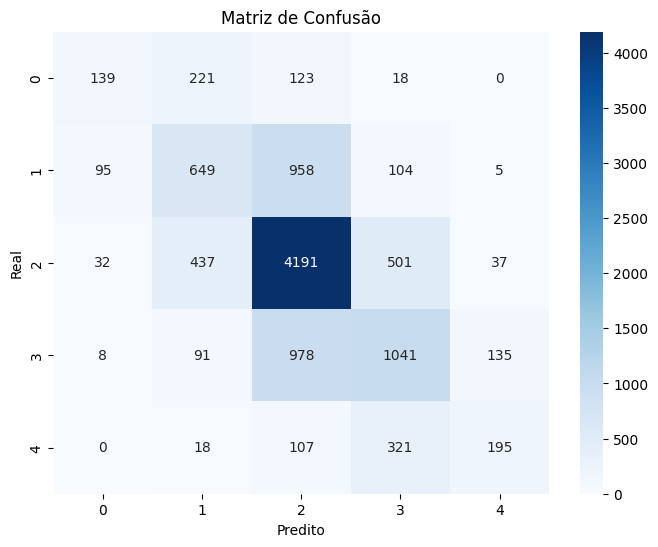

In [104]:
print("Confusion Matrix:")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## **Ajuste de Hiperparâmetros (Tuning)**

In [105]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Definir a grade de hiperparâmetros a serem testados

In [106]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],       
    'loss': ['hinge', 'squared_hinge'],      
    'penalty': ['l2']
    }

Criar o objeto GridSearchCV

In [107]:
grid_search = GridSearchCV(model, 
                            param_grid=param_grid, 
                            cv=5,
                            scoring='accuracy', 
                            n_jobs=-1, 
                            verbose=1)

Treinamento com Grid Search

In [108]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2']},
             scoring='accuracy', verbose=1)

Melhores Hiperparâmetros e Avaliação

In [109]:
print("\n--- Melhores Hiperparâmetros Encontrados ---")
print(grid_search.best_params_)


--- Melhores Hiperparâmetros Encontrados ---
{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}


Obtendo o melhor modelo

In [110]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_best

array([2, 3, 2, ..., 3, 2, 3], shape=(10404,))

Avaliação

In [111]:
print("\nRelatório de Classificação no Conjunto de Teste")
print(classification_report(y_test, y_pred_best))


Relatório de Classificação no Conjunto de Teste
              precision    recall  f1-score   support

           0       0.52      0.24      0.32       501
           1       0.46      0.27      0.34      1811
           2       0.63      0.86      0.73      5198
           3       0.53      0.42      0.47      2253
           4       0.51      0.25      0.34       641

    accuracy                           0.59     10404
   macro avg       0.53      0.41      0.44     10404
weighted avg       0.57      0.59      0.56     10404



Confusion Matrix:


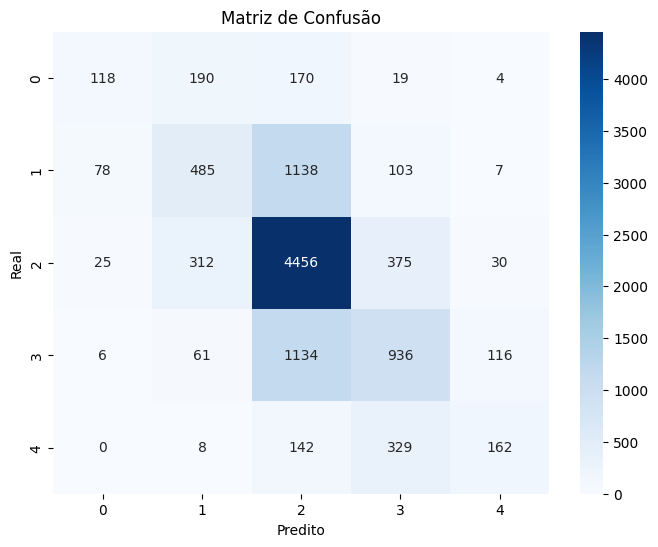

In [112]:
print("Confusion Matrix:")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# **Previsão e Submissão**

In [113]:
test.head()

,PhraseId,SentenceId,Phrase_processed
43654,199715,10623,tempting jump ship january avoid ridiculous sc...
48255,204316,10864,terrific
13645,169706,9123,decades
40638,196699,10461,notsostock characters
10925,166986,8995,one best films year


## **Fazer as Previsões no Conjunto de Teste**

In [114]:
X_test_processed = vectorizer.transform(test['Phrase_processed'])

In [115]:
y_pred_test = best_model.predict(X_test_processed)
y_pred_test

array([0, 3, 2, ..., 1, 1, 2], shape=(22100,))

## **Criar o Arquivo de Submissão**

In [116]:
test_original = pd.read_csv('Dados/test.tsv', sep='\t')
test_original.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [117]:
test_reduzido = test.sample(n=22100, random_state=42)

In [118]:
submission = pd.DataFrame({
    'PhraseId': test_reduzido['PhraseId'],
    'Sentiment': y_pred_test
})
submission.head()

,PhraseId,Sentiment
58832,214893,0
24407,180468,3
62441,218502,2
36708,192769,2
30380,186441,4


In [119]:
submission.to_csv('submission.csv', index=False)

;)